# Measuring Customers
Juan Malaver  
eCapital Advisors, LLC  
Data Science Consultant  
jmalaver@ecapitaladvisors.com

Data that records interactions between a customer and a product are often very large, which is why they're often stored in a data warehouse. We refer to these interactions as *events*.

> *Event* - a record of user behavior with a timestamp  

We want to use event data to generate a customer-level view of user behavior.

> *Metric* - summary of user behavior with a timestamp

It is important that metrics are calculated for every single customer because churn is a unique process to each one of them. We want to detect patterns in the underlying trends and observed behaviors of individual customers. We will cover some techniques that help handle event data in a general way through SQL statements. This helps streamline ETL processes and obtain summarized metrics in a computionally-effective way. Lastly, we will do some quality tests on the metrics, accounting for potential messiness in the event data.

The simulated data, code, and ideas in this notebook are inspired by Carl Gold's book ***Fighting Churn With Data: Science and strategy for keeping your customers***.

### Data Import and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
%run '../credentials/settings.py'
import os

# obtaining credentials (stored as environmental variables in .env file)
USER = os.getenv('CHURN_DB_USER')
PASS = os.getenv('CHURN_DB_PASS')
IP = os.getenv('CHURN_DB_IP')
PORT = os.getenv('CHURN_DB_PORT')
DB = os.getenv('CHURN_DB_NAME')

In [3]:
from sqlalchemy import create_engine

# SQL engine and connection
engine = create_engine('postgresql+psycopg2://{}:{}@{}:{}/{}'.format(USER, PASS, IP, PORT, DB))
connection = engine.connect()

# printing table names
print(engine.table_names(schema='churnsim'))

['event', 'subscription', 'event_type', 'metric', 'metric_name', 'active_period', 'observation', 'active_week', 'account']


## Events

Continuing with the credit card example, we can think of customer events as single transactions that are recorded on the account. There are various types of transactions: cash, merchandise, deposit, etc. We will plot one kind of event for two accounts and compare.

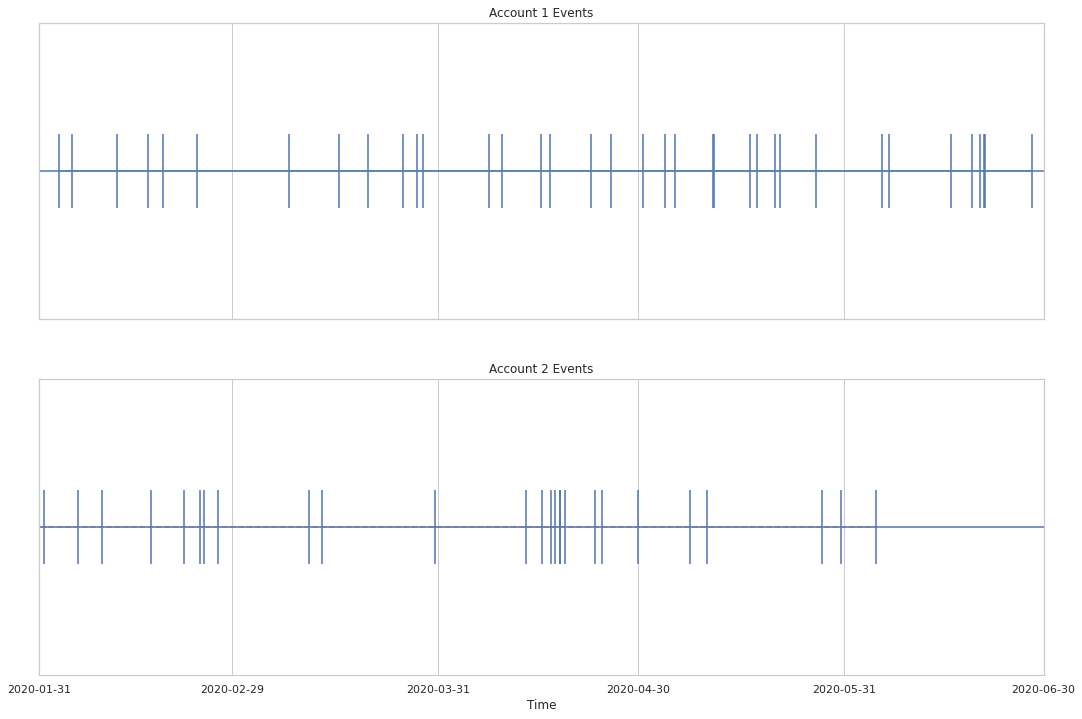

In [4]:
sns.set_style("whitegrid")
sns.set_context("notebook")
two = pd.read_sql('SELECT * FROM churnsim.event e WHERE e.event_type_id=1 AND e.account_id<3', con=engine)
fig, ax = plt.subplots(2, 1, figsize=[18, 12], sharex=True)
for i in range(2):
    g = sns.lineplot(data=two, x='event_time', y='account_id', style='account_id', hue='account_id', palette="Set2", ax=ax[i], legend=False)
    g.set(xticks=pd.date_range(start='2020-01-01', periods=6, freq='M'),yticks=[], ylabel='', xlabel='Time', title='Account {} Events'.format(i+1), xlim=['2020-01-31', '2020-06-30'], ylim=[i+0.8, i+1.2]) 
    ax[i].vlines(two[two['account_id']==i+1]['event_time'], i+0.95, i+1.05)
    ax[i].axhline(i+1, 0, 1)

plt.show()
fig.savefig('../reports/figures/events.png')

We chose a *time period* in which we will derive a churn metric.

> *Time window* - period of time in which all events that are occur are considered in a churn metric calculation

We can summarize behavior within each time window in a variety of ways. We will start simple and move on to more complex metrics. 

## Event Data

We will assume that event data is always stored in a transactional SQL database, which is almost always the case when event data occupies a lot of space. The key fields in an event data schema are as follows:

| Column | Data type |
| ----------- | ----------- |
| account_id | int |
| event_type_id | int |
| event_time | timestamp |  

This is more or less a *fact table* that does not require numeric data fields for individual events (though if they do exist they can be helpful for subsequent analysis). At a specific point in time `event_time`, a specifc customer `account_id` interacts with the product in a specifc way `event_type_id`.

## Counting Events

Using SQL logic, we can count the number of events in a specific time period. Time periods are fixed intervals that do not overlap.

1. Set a date for metric
2. Select all events in time period
3. Count all events for each account

In [5]:
stmt = '''
-- CTE for measurement date
WITH calc_date AS (
    SELECT '2020-05-06'::timestamp AS the_date
)
-- account, date, and count
SELECT account_id, COUNT(*) AS n_event_type0
FROM churnsim.event e INNER JOIN calc_date d ON
    -- period in which measurement is made
    e.event_time <= d.the_date
    AND e.event_time > d.the_date - INTERVAL '28 day'
-- filtering for specific event
WHERE e.event_type_id=0
-- one metric per account
GROUP BY account_id;
'''

In [6]:
pd.read_sql(stmt, con=engine)

,account_id,n_event_type0
0,1,145
1,2,35
2,3,4
3,5,72
4,6,7
...,...,...
11728,14602,9
11729,14604,2
11730,14605,2
11731,14612,1


## Metric Periods

### Weekly cycles

Calculating metrics over fixed intervals as opposed to conventional time windows like calendar months is a strategy that accounts for variation within weeks. Regardless of the product, customers tend to follow a weekly behavioral cycle in their interactions. For credit cards, one would expect most activity to be on the weekends, when people have more time to spend money on leisure activites. We want to capture the same number of weekends everytime we generate a behavioral metric. If we capture more high-usage weekends in one measurement, then we will artificially inflate the event count for that time period metric. We might think that for that specific time period, usage was higher, but it was instead because the time windows for the different measurements were not even. We will plot the time series variation to visualize this concept.

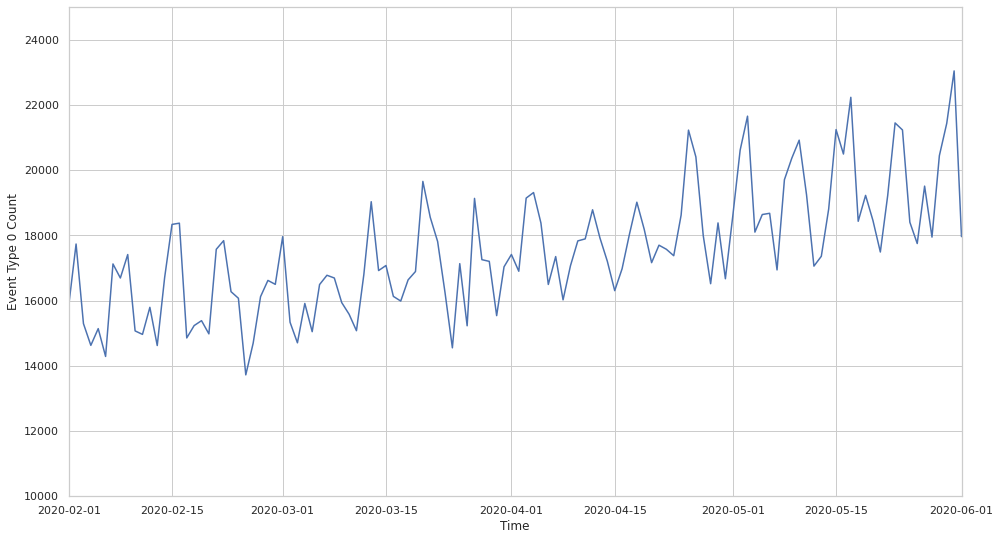

In [7]:
count = pd.read_sql('SELECT DATE(event_time), COUNT(*) AS n_event_type0 FROM churnsim.event e WHERE e.event_type_id=0 GROUP BY DATE(event_time)', con=engine)
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(16, 9))
g = sns.lineplot(data=count, x='date', y='n_event_type0')
g.set(xlim=['2020-02-01','2020-06-01'], ylim=[10000, 25000], xlabel='Time', ylabel='Event Type 0 Count')
plt.show()
fig.savefig('../reports/figures/dailycount.png')

### Working with timestamps

> *Timestamp* - date and time corresponding to an individual event and used to represent a metric  

The timestamp for a metric represents the time window domain of the metric calculation. We timestamp metrics by the next date after the measurement period ends (i.e. midnight on the next day after the time window). Having fixed timestamps for metrics is useful when we calculate several metrics, as we will be able to compare them if they correspond to the same time period. Four-week time windows and timestamping metrics as the immediate day after is an important decision in the metric design process, and it helps us keep our data tidy.

## Metrics Across Time

We will be generating metrics for each customer at different points in time to understand changes in their behavior and identify patterns related to churn.

### Overlapping windows

We will be calculating the same metric multiple times at different points of a customer's lifespan. Just because the metric is calculated on four-week intervals does not mean that we have to wait four weeks before calculating a metric. Instead, we can calculate the four-week metric every week, creating a moving time window in which we are calculating our metric. Each event is this counted four times, one in each different four-week metric that includes the week when the event occured. That is, everytime we calculate the metric, we define start and end dates for a specific time window. If the event falls between those dates, it counts towards the metric calculation.

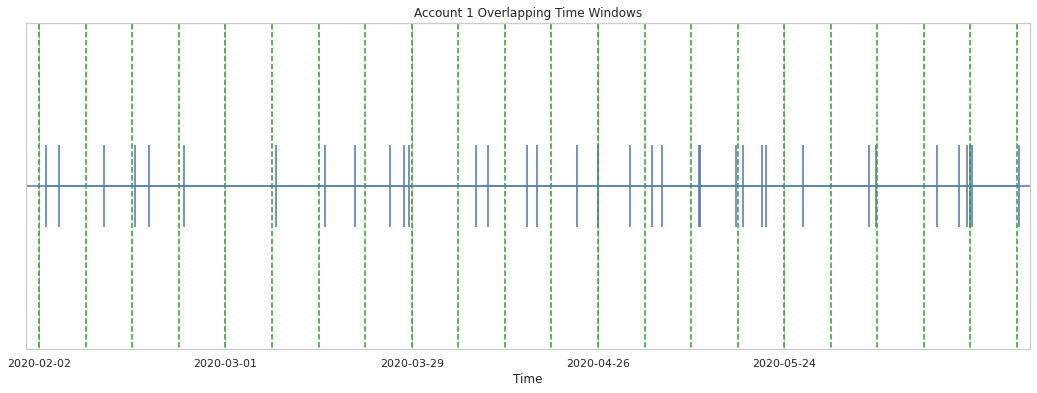

In [8]:
sns.set_style("whitegrid")
sns.set_context("notebook")
two = pd.read_sql('SELECT * FROM churnsim.event e WHERE e.event_type_id=1 AND e.account_id<3', con=engine)
fig, ax = plt.subplots(figsize=[18, 6])
i=0
g = sns.lineplot(data=two, x='event_time', y='account_id', style='account_id', hue='account_id', palette="Set2", ax=ax, legend=False)
g.set(xticks=pd.date_range(start='2020-01-01', periods=6, freq='4w'),yticks=[], ylabel='', xlabel='Time', title='Account {} Overlapping Time Windows'.format(i+1),
      xlim=['2020-01-31', '2020-06-30'], ylim=[i+0.8, i+1.2]) 
ax.vlines(two[two['account_id']==i+1]['event_time'], i+0.95, i+1.05)
ax.vlines(pd.date_range(start='2020-01-01', end='2020-07-01', freq='w'), 0.5, 1.5, linestyle='dashed', color='tab:green')
ax.axhline(i+1, 0, 1)

plt.show()
fig.savefig('../reports/figures/movingwindow.png')

We can use SQL logic to generate these metrics from an event database.

1. Choose date sequence for measurement
2. Select events for each date in measurement date sequence
3. Count all events grouping by account and measurement date

In [9]:
stmt='''
-- CTE for end dates of time windows
WITH date_vals AS (
    SELECT i::timestamp AS metric_date
    FROM generate_series('2020-01-29', '2020-04-16',
    '7 day'::interval) i
)
-- account, time, and metric
SELECT account_id, metric_date, COUNT(*)
    AS n_event_type0_per_month
FROM churnsim.event e INNER JOIN date_vals d
    ON e.event_time < metric_date
    AND e.event_time >= metric_date - INTERVAL '28 day'
WHERE e.event_type_id=0
GROUP BY account_id, metric_date
ORDER BY account_id, metric_date
'''

In [10]:
pd.read_sql(stmt, con=engine)

,account_id,metric_date,n_event_type0_per_month
0,1,2020-02-05,27
1,1,2020-02-12,69
2,1,2020-02-19,103
3,1,2020-02-26,140
4,1,2020-03-04,137
...,...,...,...
124925,13307,2020-04-15,1
124926,13308,2020-04-08,2
124927,13308,2020-04-15,13
124928,13310,2020-04-08,99


### Timing

The frequency with which we update metrics depends on the typical lifespan of a customer. If customers usually churn after a few months, then we might want to update the metric every day. Likewise, if customers usually churn after multiple years, we might want to udpate the metric every month. The dynamic of each churn scenario is unique and will drive the decision of choosing an appropriate time window. Also, if we think that people use credit cards, for example, mostly on the weekends, then we will want to calculate the metric every Monday so that we capture the activity on the most recent weekend.

### Saving metrics

We will want to create a materialized view in the data warehouse that captures all metric calculations, as this table will be necessary for subsequent analysis. This schema will have the following structure:

| Column | Data type |
| ----------- | ----------- |
| account_id | int |
| metric_name_id | int |
| metric_time | timestamp | 
| value | float |  

where the first three fields make up a composite key for the table. Here is a brief summary of the fields:

- `account_id` - identifies individual accounts
- `metric_name_id` - defines metric type
- `metric_time` - metric timestamp
- `value` - numeric value of metric

In [18]:
stmt = '''
-- CTE with dates for calculation
WITH date_vals AS (
    SELECT i::timestamp AS metric_date
    FROM generate_series('2020-01-29', '2020-04-16', '7 day'::interval) i
)
-- account, metric id, metric time, and metric value
SELECT account_id, metric_date, event_type_id AS metric_name_id,
    COUNT(*) AS metric_value
FROM churnsim.event e INNER JOIN date_vals d
    ON e.event_time < metric_date
    AND e.event_time >= metric_date - INTERVAL '28 day'
GROUP BY account_id, metric_date, metric_name_id
ORDER BY account_id, metric_date, metric_name_id; 
'''

In [19]:
pd.read_sql(stmt, con=engine)

,account_id,metric_date,metric_name_id,metric_value
0,1,2020-02-05,0,27
1,1,2020-02-05,1,2
2,1,2020-02-05,2,73
3,1,2020-02-05,3,39
4,1,2020-02-05,4,5
...,...,...,...,...
872105,13310,2020-04-15,2,95
872106,13310,2020-04-15,3,53
872107,13310,2020-04-15,4,8
872108,13310,2020-04-15,5,1


## Totals and Averages

When events have some sort of numerical value associate with it, like credit card transactions have dollar and cent amounts, we can generate additional metrics for various event types. The two most common ways to do this are:

- Total value of all events
- Average value for each event  

We can use SQL logic to calculate these total value of all events:

1. Choose date sequence for measurement
2. For each date in sequence, select associated events
3. Sum the event value field after grouping by account, date and event type  

Keep in mind that the data field which we will use for these aggregations is simply a value associated with each event. This could easily be replaced with a dollar amount field in the context of credit card transactions. We can also calculate averages by changing the SQL aggregating function.

In [13]:
stmt = '''
-- CTE with date sequence
WITH date_vals AS (
    SELECT i::timestamp AS metric_date
    FROM generate_series('2020-01-08', '2020-12-31'. '7_day'::interval) i
)
SELECT account_id, metric_date::date, event_type_id AS metric_name_id,
    SUM(event_value) AS total_value,
    AVG(event_value) AS avg_value
FROM churnsim.event e INNER JOIN date_vals d
    ON e.event_time < metric_date
    AND e.event_time >= metric_date - INTERVAL '28 day'
GROUP BY account_id, metric_date, metric_name_id
ORDER BY account_id, metric_date, metric_name_id;
'''

## Quality Assurance

After calculating metrics, we will want to take an additional step to validate our results. We output a few rows from the resulting tables in previous sections, but that is not enough to assure that the metric has been properly calculated. We want to identify issues with missing or messy data that might be impacting our derivations.

### Time-series statistics

We can look at how various descriptive statistics of a metric change over time. If we observe anything unusual, then we will know where to look. We can generate this statistical table with the following SQL logic:

1. Set date sequence to check
2. Define metric to be tested
3. Calculate results with outer join

In [38]:
stmt = '''
-- CTE with date sequence
WITH date_range AS (
    SELECT i::timestamp AS calc_date
    FROM generate_series('2020-02-05', '2020-05-06', '7 day'::interval) i 
),
-- CTE with selected metric
the_metric AS (
    SELECT * from churnsim.metric m
    WHERE m.metric_name_id=0
)
SELECT calc_date, AVG(metric_value), COUNT(the_metric.*) AS n_calc,
    MIN(metric_value), MAX(metric_value)
-- left outer join returns result for every day
FROM date_range LEFT OUTER JOIN the_metric
    ON calc_date=metric_time
GROUP BY calc_date
ORDER BY calc_date
'''

In [40]:
stats = pd.read_sql(stmt, con=engine)
stats.to_csv('../data/interim/event0_per_month.csv', index=False)
stats

,calc_date,avg,n_calc,min,max
0,2020-02-05,30.769919,9614,1.0,1043.0
1,2020-02-12,36.634719,10006,1.0,1488.0
2,2020-02-19,40.558918,10277,1.0,1763.0
3,2020-02-26,42.112722,10486,1.0,1766.0
4,2020-03-04,42.321000,10595,1.0,1783.0
5,2020-03-11,42.014467,10714,1.0,1738.0
6,2020-03-18,41.920551,10812,1.0,1717.0
7,2020-03-25,42.327344,10909,1.0,1758.0
8,2020-04-01,42.782680,10947,1.0,1731.0
9,2020-04-08,43.366489,11089,1.0,1776.0


We want the metric table to output results even if no metric was calculated. If we produced metrics for every single day, it would be computationally expensive. We want to show where no metrics were calculated and also when bad metrics were calculated. We will know plot these metrics on graph using python functions.

In [71]:
from math import ceil

# plotting function for metric statistics
def metric_qa_plot(qa_data_path, metric_name, **kwargs):
    # file saved using previous SQL statement
    metric_data_path = qa_data_path + metric_name + '.csv'
    qa_data_df=pd.read_csv(metric_data_path)
    plt.subplots(figsize=(16, 9), sharex=True, sharey=False)
    
    # using helper function
    qa_subplot(qa_data_df, 'max', 1, None)
    plt.title(metric_name)
    qa_subplot(qa_data_df, 'avg', 2, '--')
    qa_subplot(qa_data_df, 'min', 3, '-.')
    qa_subplot(qa_data_df, 'n_calc', 4, ':')
    plt.gca().figure.autofmt_xdate()
    plt.show()
    
    save_to_path=metric_data_path.replace('.csv', '.png')
    print('Saving metric qa plot to ' + save_to_path)
    plt.savefig(save_to_path)
    plt.close()
    
# helper function for each subplot
def qa_subplot(qa_data_df, field, number, linestyle):
    plt.subplot(4, 1, number)
    g = sns.lineplot(x='calc_date', y=field, data=qa_data_df, marker='',
                     linestyle=linestyle, color='black', linewidth=2, label=field)
    g.set(ylim=[0, ceil(1.1 * qa_data_df[field].dropna().max())])
    plt.legend()

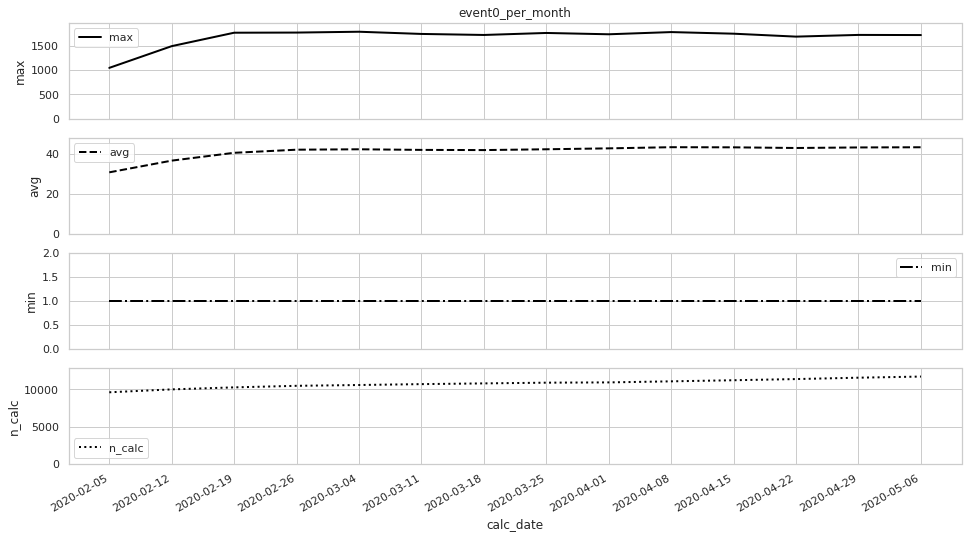

Saving metric qa plot to ../data/interim/event0_per_month.png


In [72]:
# plotting
metric_qa_plot('../data/interim/', 'event0_per_month')

### Accounts with metrics

Now we will calculate the proportion of the total population with a metric. By doing this we can get a sense of what fraction of customers are receiving a specific metric and how that proportion changes over time. The SQL logic is as follows:

1. Choose time window
2. Count all accounts active in time window
3. Count all accounts for each metric type
4. Divide step 3 by step 2 to get proportion of acccounts with metric
5. Select additional metric statistics

In [81]:
stmt = '''
-- CTE with time window
WITH date_range AS (
    SELECT '2020-04-01'::timestamp AS start_date,
        '2020-05-06'::timestamp AS end_date
), 
-- CTE with number of acccounts
account_count AS (
    SELECT COUNT(DISTINCT account_id) AS n_account
    FROM churnsim.subscription s INNER JOIN date_range d ON
    s.start_date <= d.end_date
    AND (s.end_date >= d.start_date OR s.end_date IS NULL)
)
SELECT metric_name_id,
    COUNT(DISTINCT m.account_id) AS count_with_metric,
    n_account AS n_account,
    (COUNT(DISTINCT m.account_id))::float/n_account::float
        AS pcnt_with_metric,
    AVG(metric_value) AS avg_value,
    MIN(metric_value) AS min_value,
    MAX(metric_value) AS max_value,
    MIN(metric_time) AS earliest_metric,
    MAX(metric_time) AS last_metric
-- cross join duplicates rows from account count
FROM churnsim.metric m CROSS JOIN account_count
-- limiting time period
INNER JOIN date_range ON
    metric_time >= start_date
    AND metric_time <= end_date
INNER JOIN churnsim.subscription s
    ON s.account_id = m.account_id
    AND s.start_date <= m.metric_time
    AND (s.end_date >= m.metric_time OR s.end_date IS NULL)
GROUP BY metric_name_id, n_account
ORDER BY metric_name_id;
'''

In [82]:
pd.read_sql(stmt, con=engine)

,metric_name_id,count_with_metric,n_account,pcnt_with_metric,avg_value,min_value,max_value,earliest_metric,last_metric
0,0,12006,12262,0.979122,44.408718,1.0,1776.0,2020-04-01,2020-05-06
1,1,11490,12262,0.937041,7.699694,1.0,134.0,2020-04-01,2020-05-06
2,2,12130,12262,0.989235,100.294614,1.0,4956.0,2020-04-01,2020-05-06
3,3,12010,12262,0.979449,42.825876,1.0,1583.0,2020-04-01,2020-05-06
4,4,11797,12262,0.962078,16.545238,1.0,611.0,2020-04-01,2020-05-06
5,5,5467,12262,0.445849,1.164553,1.0,5.0,2020-04-01,2020-05-06
6,6,11980,12262,0.977002,62.803840,1.0,5059.0,2020-04-01,2020-05-06
7,7,11331,12262,0.924074,26.348861,1.0,1150.0,2020-04-01,2020-05-06


## Event Data QA

We will know do some quality assurance tests on the event data itself. This is important as it helps in the metric design process, especially when choosing how to calculate metrics.

### Events over time

We plotted event counts previously in a relatively informal manner. We will now formalize the approach of extracting time series for event data and creating data visualizations. In the credit card context, this would be the total number of transactions type 0 (e.g. cash transactions) each day across all accounts.

In [90]:
stmt = '''
-- CTE with date range
WITH date_range AS(
    SELECT i::timestamp AS calc_date
    FROM generate_series('2020-01-01', '2020-12-31', '1 day'::interval) i 
)
-- event time to dates
SELECT event_time::date as event_date,
    -- total number of events
    COUNT(*) AS n_event
    -- sum event properties
        /*, SUM(optional_field) AS total_field */
FROM date_range LEFT OUTER JOIN churnsim.event e
    ON calc_date=event_time::date
WHERE e.event_type_id=0
GROUP BY event_date
ORDER BY event_date
'''

In [91]:
event = pd.read_sql(stmt, con=engine)
event.to_csv('../data/interim/event0_qa.csv', index=False)
event

,event_date,n_event
0,2020-01-01,566
1,2020-01-02,939
2,2020-01-03,1636
3,2020-01-04,2160
4,2020-01-05,3053
...,...,...
177,2020-06-26,4081
178,2020-06-27,3387
179,2020-06-28,2816
180,2020-06-29,983


In [100]:
# plotting function for time series event data
def event_count_plot(qa_data_path, event_name, **kwargs):
    event_data_path = qa_data_path + event_name + '.csv'
    qa_data_df = pd.read_csv(event_data_path)
    plt.figure(figsize=(16, 9))
    g = sns.lineplot(x='event_date', y='n_event', data=qa_data_df,
                 marker='', color='black', linewidth=2)
    g.set(ylim=[0, ceil(1.1*qa_data_df['n_event'].dropna().max())])
    plt.title('{} count'.format(event_name))
    plt.gca().figure.autofmt_xdate()
    plt.xticks(list(filter(lambda x:x.endswith(('01')),
                          qa_data_df['event_date'].tolist())))
    plt.tight_layout()
    plt.show()
    plt.savefig(event_data_path.replace('.csv', '.png'))
    plt.close()

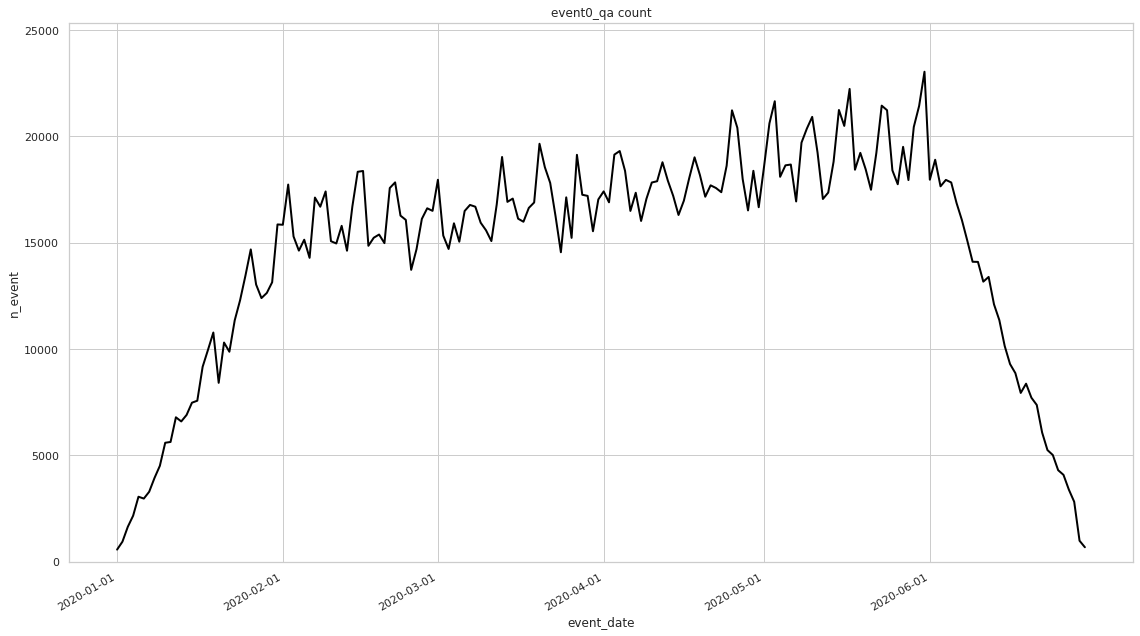

In [99]:
event_count_plot('../data/interim/', 'event0_qa')

### Events per account

Now we will calculate how many events exist per account. This is similar to checking the number of accounts with metrics, but now we are doing it at the event level. We should be doing this for all event types individually and as a whole. In the context of credit cards this would be counting all transaction types and counting for each account. The SQL logic needed to implement this is as follows:

1. Set date range
2. Count all active accounts in date range
3. Count total number of events in date range
4. Divide total events by:
    1. number of accounts
    2. number of months measured

In [107]:
stmt = '''
-- CTE for date range
WITH date_range AS (
    SELECT '2020-01-01'::timestamp AS start_date,
        '2020-12-31'::timestamp AS end_date
),
-- CTE for number of accounts
account_count AS (
    SELECT COUNT(DISTINCT account_id) AS n_account
    FROM churnsim.subscription s INNER JOIN date_range d ON
    s.start_date <= d.end_date
    AND (s.end_date >= d.start_date OR s.end_date IS NULL)
)
SELECT event_type_id,
    COUNT(*) AS n_event,
    n_account AS n_account,
    -- events per account
    COUNT(*)::float/n_account::float
        AS events_per_account,
    -- count of four-week months
    EXTRACT(days FROM end_date-start_date)::float/28.0
        AS n_months,
        -- events per account per month
        (COUNT(*)::float/n_account::float)/(EXTRACT(days FROM end_date-start_date)::float/28.0)
            AS events_per_account_per_month
FROM churnsim.event e CROSS JOIN account_count
INNER JOIN date_range ON
    event_time >= start_date
    AND event_time <= end_date
GROUP BY e.event_type_id, n_account, end_date, start_date
ORDER BY events_per_account_per_month DESC;
'''

In [108]:
pd.read_sql(stmt, con=engine)

,event_type_id,n_event,n_account,events_per_account,n_months,events_per_account_per_month
0,2,6147279,14641,419.867427,13.035714,32.209008
1,6,3788020,14641,258.726863,13.035714,19.847540
2,0,2676530,14641,182.810600,13.035714,14.023827
3,3,2589660,14641,176.877262,13.035714,13.568667
4,7,1438987,14641,98.284748,13.035714,7.539652
5,4,972607,14641,66.430367,13.035714,5.096028
6,1,428467,14641,29.264873,13.035714,2.244977
7,5,18614,14641,1.271361,13.035714,0.097529


This QA strategy is meant to help us identify events that don't occur as often as others. Whether a low number of events per account per month is a bad thing depends on the business context. For example, we would not expect a credit card holder to make balance payments every single day, whereas we might expect them to make merch transactions several times throughout the week. We sort the events by their frequency to show the order of their expected counts. 

## Measurement Period

If an event is rare, then we will want to change the measurement period when calculating metrics. Events that occur less often should be measured over longer periods of time. We want to find a balance between the metric's *sensitivity* to rare events and the metric's *responsiveness* to changes in time. A metric with longer time periods tends to be less responsive and more sensitive to accounts with loew event levels. A good rule of thumb is to chose a time period that's at least twice as long as the average time it takes for an account to have the event. This period should never be less than a week and no more than one year. We will want to continue with the previous strategy of choosing fixed number weekly intervals. Here is a table summarizing this rule.

| Events per account per month | Months for one event | Minimum measurement window |
| ----------- | ----------- | ----------- |
| >8 | <0.1 | 1 week |
| 8 | 0.125 | 1 week |
| 4 | 0.25 | 2 weeks |
| 2 | 0.5 | 1 month |
| 1 | 1 | 2 months |
| 0.5 | 2 | 4 months |
| 0.333 | 3 | 6 months |
| 0.25 | 4 | 8 months |
| 0.1666 | 5 | 12 months |
| <0.1666 | 6 | 12 months |  

When considering measurement windows for credit cards, keep in mind that metrics should be similar in scale to 1 month because billing cycles occur every month. If the metric is too rare to capture in monthly windows, then we could expand the time window, though this might not reflect the customer experience with their credit card accounts. The main reason behind choosing an appropriate measurement period is to understand how we can compare different events and use this reasoning to analyze churn. We will see how to generate metrics on different time windows and compare them in a subsequent notebook.

## Account Tenure

We have almost exclusively used event data up to this point, and now we will also leverage billing cycle data. The length of time an account has been active is defined as *account tenure*, which is a fundamental piece of analyzing churn.

### Definition

Account tenure is essentially the amount of time between an account's start date and the time the measurement is made. That does not necessarily mean that the start date is the same as when the account was opened, because a customer can have gaps of inactivity throughout their lifespan which we would consider the end of a tenure. That is, an old account who churned is not considered an account with long tenure because they were not active since open. We want, however, to allow small gaps of inactivity to exist before declaring a churn. It depends on how long the account was inactive and whether that length exceeds some specified threshold. The value of this threshold depends on the business context, though we can stick with using 1 month as that runs parallel to credit card billing cycles. In order words, customers that have not used their credit cards for up to one month are not considered inactive.

> *Account tenure* - the amount of time that a customer has remained engaged to the product without any large gaps of inactivity

### SQL account tenure

Using recursive CTEs we can describe the SQL logic needed to calculate account tenure.

1. Set date range
2. Recursively find earliest start dates for each account
3. Calculate days since earliest start date

In [109]:
stmt = '''
-- recursive CTE with date range
WITH RECURSIVE date_range AS (
    SELECT '2020-06-01'::date AS calc_date
),
-- start dates for each account
earlier_starts AS (
    SELECT account_id, MIN(start_date) AS start_date
    FROM churnsim.subscription INNER JOIN date_range
        ON start_date <= calc_date
        AND (end_date > calc_date OR end_date IS NULL)
    GROUP BY account_id
    -- add results without duplicating
    UNION
    -- new accounts and start dates
    SELECT s.account_id, s.start_date
    FROM churnsim.subscription s INNER JOIN earlier_starts e
        ON s.account_id=e.account_id
        AND s.start_date < e.start_date
        -- end date must be within short gap length
        AND s.end_date >= (e.start_date-31)
)
SELECT account_id, MIN(start_date) AS earliest_start,
    -- select earliest start date for each account
    calc_date-MIN(start_date)
        AS account_tenure_days
-- duplicate calc_date on every row
FROM earlier_starts CROSS JOIN date_range
GROUP BY account_id, calc_date
ORDER BY account_id;
'''

In [110]:
pd.read_sql(stmt, con=engine)

,account_id,earliest_start,account_tenure_days
0,1,2020-01-29,124
1,2,2020-01-06,147
2,3,2020-01-18,135
3,5,2020-01-19,134
4,6,2020-01-31,122
...,...,...,...
12280,14637,2020-05-27,5
12281,14638,2020-05-07,25
12282,14639,2020-05-27,5
12283,14640,2020-05-28,4


## MRR and Other Metrics

We can generate metrics that are not just dependent on the dates of billing cycles, but also on revenue streams during those cycles. We will describe an approach that is generalized to multi-product business models.

### MRR

Total monthly recurring revenue (MRR) is measured at different points in time, aligned with billing cycles, which means it behaves in a similar way to other metrics we have already calculated. Here is the SQL logic outline to calculate MRR as a behavioral metric:

1. Set measurement date sequence
2. Join billing cycle table with dates and find all active products on each date
3. Sum total MRR for all products on each date

In [113]:
stmt = '''
-- CTE with measurement dates
WITH date_vals AS(
    SELECT i::timestamp AS metric_date
    FROM generate_series('2020-04-02', '2020-04-09', '7 day'::interval) i
)
-- sum total mrr
SELECT account_id, metric_date, SUM(mrr) AS total_mrr
FROM churnsim.subscription INNER JOIN date_vals
    ON start_Date <= metric_date
    AND (end_date > metric_date OR end_date IS NULL)
GROUP BY account_id, metric_date
ORDER BY account_id, metric_date
'''

In [114]:
pd.read_sql(stmt, con=engine)

,account_id,metric_date,total_mrr
0,1,2020-04-02,9.99
1,1,2020-04-09,9.99
2,2,2020-04-02,9.99
3,2,2020-04-09,9.99
4,3,2020-04-02,9.99
...,...,...,...
21797,13301,2020-04-09,9.99
21798,13302,2020-04-02,9.99
21799,13302,2020-04-09,9.99
21800,13308,2020-04-09,9.99


### Units, quantity, and billing cycles

Different products have different characteristics that distinguish them from each other.

> *Unit* - entitlement offered by ownership of the product  
> *Quantity* - how many units customer is entitled to

We can think of credit card units as the capacity to make transactions and pay them off at a later date. We can think of quantity as limits on the number of transactions made on the credit card or the credit limit itself, which is a limit on the total dollar amount spent by customers. We want to include these properties in our analysis by adding a unit and quantity column to our schema. The unit column describes the entitlement (e.g. dollar transacations) and the quantity column shows the corresponding amount (e.g. amount spent).

> *Charge segment* - recurring contract for a certain quantity of unit (e.g. transaction fee)

### Units as metrics

We will now outline the SQL logic needed to calculate the quantity a customer is entitled to for each unit. 

1. Set date sequence
2. Join billing cycle data to find all active accounts at each date
3. Limit accounts to those with correct units
4. Sum all matching accounts on each date

In [115]:
stmt = '''
-- CTE with measurement dates
WITH date_vals AS(
    SELECT i::timestamp AS metric_date
    FROM generate_series('2020-04-02', '2020-04-09', '7 day'::interval) i
)
-- sum total mrr
SELECT account_id, metric_date, SUM(quantity) AS total_quantity
FROM churnsim.subscription INNER JOIN date_vals
    ON start_Date <= metric_date
    AND (end_date > metric_date OR end_date IS NULL)
WHERE units = ''
GROUP BY account_id, metric_date
ORDER BY account_id, metric_date
'''

### Billing periods as metrics

> *Billing period* - how often the customer is billed (e.g. monthly billing is a billing period of 1)  

We can aggregate accounts that have billing cycles at the same intervals to generate a metric based on billing periods. Nonetheless, having multiple products with different billing cycles is uncommon. For example, if one account holds two credit cards, they will both be billed on a monthly basis. Either way, we will want to aggregate on a specific date for each account even if that account own more than one product. If a customer holds another product that has a different billin structure, they will still behave based on their smallest interval. That is, if a person holds a checking account with an annual fee in additional to a credit card with a monthly billing cycle structure, they will behave like someone who gets billed each month, so we calculate the minimum in the SQL statement.

In [116]:
stmt = '''
-- CTE with measurement dates
WITH date_vals AS(
    SELECT i::timestamp AS metric_date
    FROM generate_series('2020-04-02', '2020-04-09', '7 day'::interval) i
)
-- sum total mrr
SELECT account_id, metric_date, MIN(bill_period_months) AS billing_period
FROM churnsim.subscription INNER JOIN date_vals
    ON start_Date <= metric_date
    AND (end_date > metric_date OR end_date IS NULL)
GROUP BY account_id, metric_date
ORDER BY account_id, metric_date
'''